In [2]:
import sys 
sys.path.append("./pocomc/")

import os
import time
import pickle
import roadrunner as rr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import qmc
from multiprocessing import Pool

import pocomc as pc

SEED = 1
np.random.seed(seed=SEED) # for reproducability 

n_cpus = os.cpu_count() # n_cpus stores # of cores 
print('This machine has {} CPUs'.format(n_cpus))

This machine has 10 CPUs


In [3]:
# Model class used to define functions 
class Model:

    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values
        # Default model output to times and experimental observables
        self.observables= list(self.data.columns)[1:] # makes a list of the columns of data (not including 1st column)
        self.defaultOutput= ['time'] + self.observables # makes a list with time and data from self.observables
        self.n_params= len(self.params) # sets n_params as the number of elements in self.params
        self.n_obs= len(self.observables) # sets n_obs as the number of cols of data drom self.observables

    # __call__ lets you turn instance of class into callable object 
    def __call__(self, theta_new): # takes parameter theta_new and self referring to instance of the class
        theta_new = theta_new # why do we have to do this
        res = self.log_likelihood(theta_new) # res is the log likelihood of the parameter theta_new
        return res # returns the log likelihood 
    
    def run(self, params=None, x0=None, times=None, output=None): # executes simulation with 4 optional parameters (since =None)
        rr = self.rr # sets up integrator
        rr.reset() # resets integrator each time its called 
        rr.integrator.absolute_tolerance = 1e-12 
        rr.integrator.relative_tolerance = 1e-12
        addZero=False # initializes addZero object to false 

        # checks for function parameters, if not, sets them to specific values stored in class 
        # Use timepoints of data as default times at which to get sim output
        if params is None:
            params= self.p_true # name of parameters from bngl
        if x0 is None:
            x0= self.x0 # initial conditions 
        if times is None:
            times= list(self.data['time'].values) # times 
        # make sure zero is first time point
        if (times[0]>0.0):
            addZero= True
            times= [0] + times # adds a 0 if it doesnt start from 0

        # Set default output are the column names of the data
        if output is None: # checks if there is a defined output
            output= self.defaultOutput
       
        # Set parameter values
        for name, value in zip(self.params, params):
            rr[name] = float(value) # sets parameters in integrator, rr
        #rr.reset() # force update of parameter expression (POSSIBLY NOT NEEDED)

        # NOTE: If you want to vary the initial conditions, do this by defining a parameter in the model that sets the initial concentration of species and then include this parameter in your list of parameters to fit. 

        # Run trajectories
        try:
            traj = rr.simulate(times=times,selections=output) # rr.simulate runs the simulation
        except:
            # If integration fails return empty array
            return([])

        if (addZero):
            # Return traj with zero timepoint removed
            return(traj[1:,:])
        else:
            return(traj) # returns trajectories from simulation
        
    # cals the log of prior probability of parameters in theta_new
    def log_prior(self, theta_new): 
        # creates list of boolean values to state if theta_new is within bounds 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: 
            return 0.0 
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    # calcs log likelihood of observed data given params 
    def log_likelihood(self, theta_new): #how good is this candidate parameter fitting my data (maximize it)
        params = theta_new[:self.n_params] # gets parameter values 
        if self.fit_x0: 
            x0 = theta_new[self.n_params:(self.n_params + len(self.x_0))] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0
        # runs simulation with initial conditions and parameters 
        y = self.run(params=params, x0=x0)[:,1:] #sets y to the y results of solving ODE
        # y is the predictions 
        if (len(y)==0): # if simulaation fails 
            # return large (but not infinite value) if integration fails
            return(-1e11) # shows that really not likely 
        if (np.any(np.isnan(y))):
            return(-1e12)

        if self.fit_sigma: # sigma is standard deviation of each observable 
            sigma = theta_new[-len(self.observables):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observables) #makes all sigmas default to 1 meaning equal confidence 

        obs = self.data.values[:,1:] #sets data

        # Calculate likelihood, sum of squared differences, normalized by sigma 
        #term1 = 0 #-0.5 * np.log(2*np.pi*np.square(sigma))
        #term2 = sum (y-obsnp.square(np.subtract(y, obs)) / (2*np.square(sigma))
        #logLH = np.sum(term1 - term2)
        ll= -sum(((y-obs)/(sigma))**2)# chi^2
        return(ll[0]) # returns summed log 

In [4]:
mod_opts = {} # initializes a dictonary 
# load data for model
mod_df = pd.read_csv('onePercNoise_mRNA_data.csv', header=0, delimiter=",") #reads in data file
mod_opts['data'] = mod_df # stores mod_df data under 'data' key in dict 
# Load in SBML model using libroadrunner
sbml_file = "mRNAlog_sbml.xml" 
mod_opts['rr'] = rr.RoadRunner(sbml_file) # initialize roadrunner for model
mod_opts['params'] = ["log_param0", "log_param1", "log_param2", "log_param3", "log_param4"] # names of parameters
mod_opts["species"] = ["S1", "S2", "S3"] # species sbml names 
mod_opts['x0'] = [10, 5, 0] # initial conditions (if given)

# ! TO DO: we currently assume it fit_x0, then ALL species initial conditions are fit
mod_opts['fit_x0'] = False # when false, does not change initial conditions 
mod_opts['fit_sigma'] = False # when false, does not change sigma (std?)
mod_opts['p_true'] = [1, -0.301, 1, 0.3031, 0] #guess param values(in log)
mod_opts['lower_bnds'] = [0.0, -1.3, 0, -0.7, -1.0] #lower bounds(in log)
mod_opts['upper_bnds'] = [2, 0.7, 2, 1.3, 1] #upper bounds(in log)

model = Model(mod_opts)

In [5]:
model.rr['log_param2']=0 # sets parameters value to 0
model.rr.reset() # resets model to initial conditions 
print("mRNA initial concentration:", np.log10(model.rr['init(S1)']))
print("mRNA initial concentration:", np.log10(model.rr['mRNA0']))
print("p1 initial concentration:", np.log10(model.rr['init(S2)']))
print("p1 initial concentration:", np.log10(model.rr['p10']))

mRNA initial concentration: 1.0
mRNA initial concentration: 1.0
p1 initial concentration: 0.6989700043360189
p1 initial concentration: 0.6989700043360189


10.0


Text(0.5, 1.0, 'mRNA Concentration')

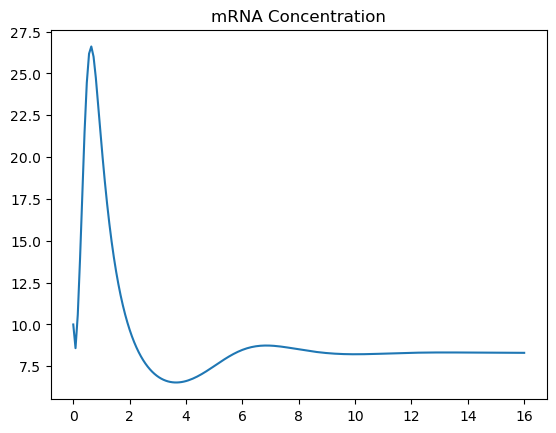

In [6]:
# runs model with given set of parameters, this can be changed []
# traj is array: rows are time, cols are concentraation
traj= model.run(params=model.p_true,times=np.linspace(0,16,201))
plt.plot(traj[:,0],traj[:,1]) # plots first observable (2nd col of traj) against time 
print(traj[0,1]) # prints initial condition of the first observable  
plt.title("mRNA Concentration")

Come back to this

Text(0.5, 1.0, 'mRNA Concentration')

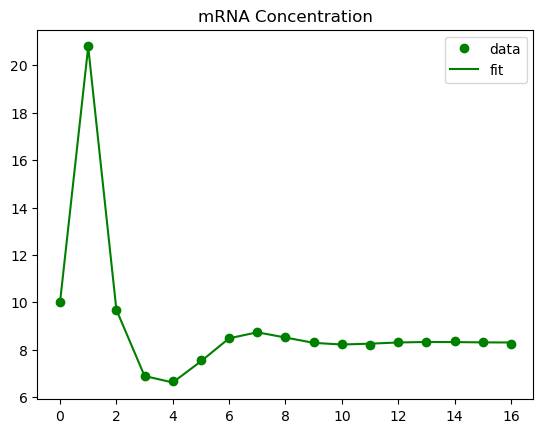

In [7]:


traj= model.run(params=model.p_true,output=list(model.data.columns))
plt.plot(model.data['time'].values,model.data['mRNA'].values,'go',label='data')
plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
_=plt.legend()
plt.title("mRNA Concentration")

In [8]:
# function to plot model fit 
def plot_fit(p):
    # simulates model with parameters over specific time frame
    ## traj has time and conentration 
    traj= model.run(params=p,times=np.linspace(0,16,201))
    # plots experimental data 
    plt.plot(model.data['time'].values,model.data['mRNA'].values,'go',label='data')
    # plots model fit 
    plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
    # log likelihood to calc cost of the fit 
    cost= model.log_likelihood(p)
    plt.title(f'Fit for $\chi^2=${-cost:0.2e}')
    _=plt.legend()

come back here to understand this

In [9]:
# use to find best param values (minimizes chi-square)
from scipy.optimize import minimize, fsolve
# 
chisq= lambda p: -model.log_likelihood(p)
# x0 is guess for params 
bf = minimize(chisq, x0=[1, 0, 1, 0, 0], method='nelder-mead',options={'maxiter':1000})
print(bf)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.20845876466668858
             x: [ 1.013e+00 -2.048e-02  9.390e-01 -8.853e-02 -7.132e-03]
           nit: 332
          nfev: 550
 final_simplex: (array([[ 1.013e+00, -2.048e-02, ..., -8.853e-02,
                        -7.132e-03],
                       [ 1.013e+00, -2.048e-02, ..., -8.853e-02,
                        -7.133e-03],
                       ...,
                       [ 1.013e+00, -2.048e-02, ..., -8.853e-02,
                        -7.131e-03],
                       [ 1.013e+00, -2.048e-02, ..., -8.854e-02,
                        -7.129e-03]]), array([ 2.085e-01,  2.085e-01,  2.085e-01,  2.085e-01,
                        2.085e-01,  2.085e-01]))


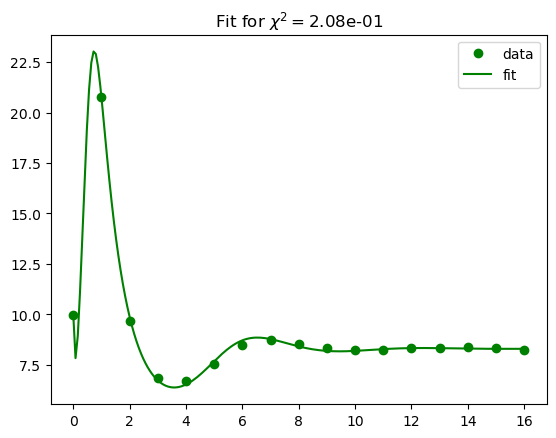

In [10]:
plot_fit(bf.x)

In [11]:
n_particles = 1000
# Initialise particles' positions using samples from the prior 
sampler = qmc.LatinHypercube(d=model.n_params, seed=SEED)
sample = sampler.random(n=n_particles) 
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=model.lower_bnds, u_bounds=model.upper_bnds)
print(prior_samples.shape)

The discrepancy of the sampling (i.e., sample quality): 0.0004
(1000, 5)


In [12]:
t0 = time.time() #stores current time, date, year, etc. in one float
# with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    
sampler = pc.Sampler(n_particles = n_particles,
                n_dim = model.n_params,
                log_likelihood = model.log_likelihood,
                log_prior = model.log_prior,
                bounds = np.array(list(zip(model.lower_bnds, model.upper_bnds))),
                random_state=SEED,
                vectorize_likelihood=False,
                vectorize_prior=False,
                infer_vectorization=False
            ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
result = sampler.results #results of sampler.run on prior_samples

with open('tester01_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

# we need to remove the librr simulator from the class in order to successfully save and load the class from a pkl file. 
#del model.rr
with open('tester01_mod.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(model.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run

Iter: 38it [03:07,  4.94s/it, beta=1, calls=124000, ESS=0.969, logZ=-11.3, accept=0.223, N=3, scale=1.06, corr=0.72]       


Elapsed time:  00:03:12


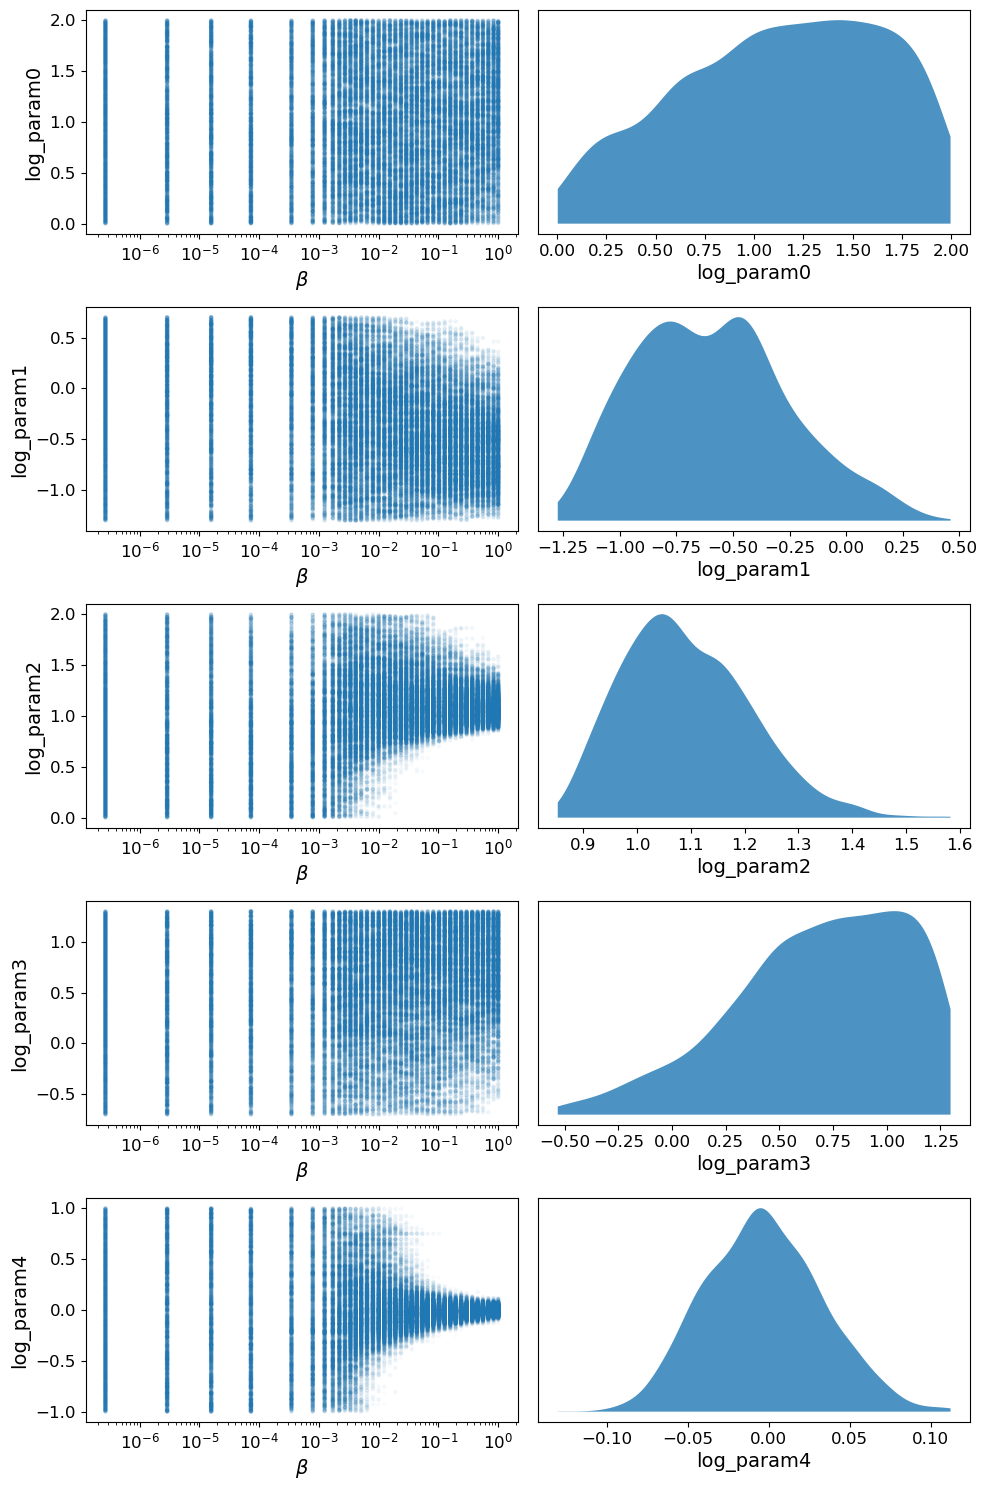

In [12]:
pc.plotting.trace(result, labels=model.params);